In [1]:
import sys
import torch
sys.path.append("/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/BasicExample")
from datasets.Regression.toydataset import create_dataset, sinus_mapping, dataset_to_loader, visualize_predictions
from src.network.feature_extractor import FC_Net
from src.network import LikApprox
from src.weight_distribution.Full import FullCovariance
from datetime import datetime
from src.network.Regression import LLVIRegression

In [2]:
# hyperparameters
lr = 1e-5
samples_list = [1, 1, 100, 1000, 10000]
vi_train_epochs = 1000

In [3]:
# data saver
mc_train_losses = []
mc_train_times = []

In [4]:
# create train set
data_noise = 0.2
x_train, y_train, x_test, y_test = create_dataset(lower=-5, upper=7, mapping=sinus_mapping,cluster_pos=[-0.5,2], data_noise=data_noise, n_datapoints=256)

# batch train set
train_set, test_set = dataset_to_loader(x_train, y_train, x_test, y_test , batch_size=16)

# define feature extractor
feature_extractor = FC_Net(layers=[1, 200, 100], nll = torch.nn.Tanh(),lr=lr, weight_decay=0.1)

In [5]:
# go over all mc methods
for samples in samples_list:
    torch.manual_seed(5)
    dist = FullCovariance(100, 1, lr=lr, init_log_var=-0.5)
    net = LLVIRegression(100, 1, feature_extractor, dist, prior_log_var=-6,
    tau=0.01, data_log_var=torch.log(torch.tensor([0.04])),
    lr=lr)
    net.train_without_VI(train_set, epochs=100)
    start_time = datetime.now()
    train_loss = net.train_model(train_set, epochs=vi_train_epochs, n_datapoints=256, samples=samples, method=LikApprox.MONTECARLO)#, train_hyper=True, update_freq=5)
    total_time = int((datetime.now() - start_time).total_seconds())
    mc_train_losses.append(train_loss)
    mc_train_times.append(total_time)

prediction_loss:0.3 kl_loss:2.73: 100%|██████████| 1000/1000 [00:51<00:00, 19.45it/s] 


In [6]:
# finally do closed form
torch.manual_seed(5)
dist = FullCovariance(100, 1, lr=lr, init_log_var=-0.5)
net = LLVIRegression(100, 1, feature_extractor, dist, prior_log_var=-6,
tau=0.01, data_log_var=torch.log(torch.tensor([0.04])),
lr=lr)
train_set, test_set = dataset_to_loader(x_train, y_train, x_test, y_test , batch_size=16)

vi_train_epochs = 1000

net.train_without_VI(train_set, epochs=100)
start_time = datetime.now()
cf_train_loss = net.train_model(train_set, epochs=vi_train_epochs, n_datapoints=256, method=LikApprox.CLOSEDFORM)#, train_hyper=True, update_freq=5)
cf_total_time = int((datetime.now() - start_time).total_seconds())

prediction_loss:0.01 kl_loss:2.78: 100%|██████████| 1000/1000 [00:42<00:00, 23.72it/s]


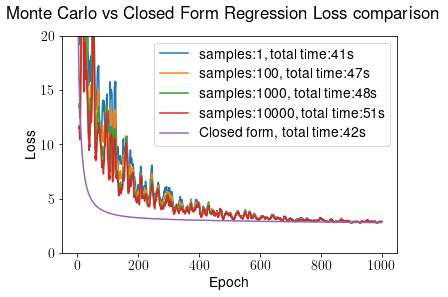

In [9]:
# visualization
from matplotlib import pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 14,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

fig, ax = plt.subplots()
for samples, train_loss, train_time in zip(samples_list[1:], mc_train_losses[1:], mc_train_times[1:]):
    # ax.plot(list(range(vi_train_epochs)), train_loss["prediction_loss"], label=f"samples:{samples}, total time:{train_time}s", alpha=0.5)
    # or with smoothing
    ax.plot(list(range(vi_train_epochs)), (train_loss["prediction_loss"] + train_loss["kl_loss"]).rolling(7).mean(), label=f"samples:{samples}, total time:{train_time}s")


ax.plot(list(range(vi_train_epochs)), (cf_train_loss["prediction_loss"] + cf_train_loss["kl_loss"]), label=f"Closed form, total time:{cf_total_time}s") 

ax.legend()
ax.set_ylim(0, 20)
fig.suptitle("Monte Carlo vs Closed Form Regression Loss comparison")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.savefig("/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/BasicExample/results/Regression/cf_mc_comparison/loss_comparison_extended.jpg")